# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from bs4 import BeautifulSoup

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,auc,roc_curve,classification_report,precision_score,recall_score,f1_score, hamming_loss

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from prettytable import PrettyTable

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:\Study_materials\Applied_AI\Assignments\database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 limit 50000""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (50000, 10)


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

In [10]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [3] Preprocessing

In [11]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

10
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!


In [12]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"didn't", 'than', 'themselves', 'then', 'nor', 'up', "you'll", 'i', 'that', 'of', 's', 'needn', 'again', "doesn't", "you're", "shan't", "don't", 'hasn', 'most', 'their', 'our', "it's", 'did', 'isn', 'my', 'other', 'out', 'off', 'd', 'during', 'wasn', 'now', 'with', 'ma', 'between', 'himself', 'it', 'so', 't', 'will', 'how', "wasn't", "should've", "shouldn't", 'as', 'mightn', 'down', 'yourself', 'weren', "that'll", 'by', 're', 'has', 'once', 'should', 'me', 'him', 'here', 'below', 'above', 'what', 'is', 'mustn', 'had', 'where', 'its', 'having', 'after', 'there', 'these', 'no', 'who', 'll', "hadn't", 'ours', 'in', 'few', 'they', "needn't", 'more', 'very', "aren't", "won't", 'yourselves', 'theirs', 'until', 'does', 'them', 'from', 'hers', 'she', 'but', 'm', "you've", 'have', 'haven', "mustn't", 'or', 'won', "wouldn't", "isn't", 'do', 'on', 'doesn', "weren't", 'a', 'hadn', 'about', 'this', 'not', 'those', 'through', 'an', "haven't", 'we', 'itself', 'which', 'yours', 'under', 'own', 'if', 

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.

final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

100%|███████████████████████████████████████████████████████████████████████████| 46071/46071 [01:57<00:00, 391.92it/s]


In [15]:
final = final.sort_values('Time',axis = 0,ascending = True, inplace = False, kind = 'quicksort', na_position='last')

In [16]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [17]:
X  = final['CleanedText'].values

## Techniques for vectorization :--

### 1. Bag of Words (BoW)

In [18]:
count_vec = CountVectorizer()
BOW_X = count_vec.fit_transform(X)

In [20]:
print("the type of count vectorizer :",type(BOW_X))
print("the shape of out text BOW vectorizer : ",BOW_X.get_shape())
print("the number of unique words :", BOW_X.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (46071, 24780)
the number of unique words : 24780


### Bi-Grams and n-Grams

In [21]:
count_vec = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
bigram_BOW_X = count_vec.fit_transform(X)
print("the type of count vectorizer ",type(bigram_BOW_X))
print("the shape of out text BOW vectorizer ",bigram_BOW_X.get_shape())
print("the number of unique words including both unigrams and bigrams ", bigram_BOW_X.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 5000)
the number of unique words including both unigrams and bigrams  5000


### 2. TF-IDF

In [39]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2), min_df = 1000)
tfidf_X = tf_idf_vec.fit_transform(X)

print("The type of count vectorizer ",type(tfidf_X))
print("The shape of out text TFIDF vectorizer ",tfidf_X.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_X.get_shape()[1])

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (46071, 318)
the number of unique words including both unigrams and bigrams  318


### 3. Avg-W2V

In [24]:
i=0
list_sent=[]
for sent in X:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent.append(filtered_sentence)

In [25]:
import gensim
w2v_model = gensim.models.Word2Vec(list_sent,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [26]:
def avg_w2v(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)        
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [27]:
avgw2v_X = avg_w2v(list_sent)

46071
50


### 4. TF_IDF-W2V

In [28]:
tf_idf_vect = TfidfVectorizer()
tfidf_X = tf_idf_vect.fit_transform(X)
print("The type of count vectorizer ",type(tfidf_X))
print("The shape of out text TFIDF vectorizer ",tfidf_X.get_shape())

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (46071, 24780)


In [29]:
t = tf_idf_vect.get_feature_names()
tfidf_w2v_X = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in tqdm(list_sent):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_X[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_w2v_X.append(sent_vec)
    row += 1
print(len(tfidf_w2v_X))
print(len(tfidf_w2v_X[0]))

100%|████████████████████████████████████████████████████████████████████████████| 46071/46071 [25:42<00:00, 29.87it/s]


46071
50


## K-Means clustering

### Applying K-Means on BOW:

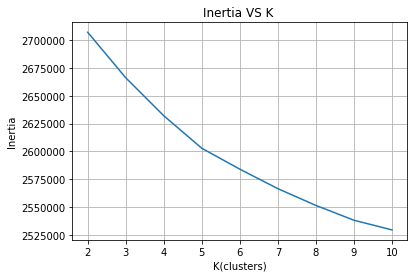

In [30]:
from sklearn.cluster import KMeans

k=[2,3,4,5,6,7,8,9,10]
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(BOW_X)
    inertia.append(model.inertia_)
    
#Applying elbow method to find best k
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [31]:
#at k=5 there is a point of deflection

k=5
model=KMeans(n_clusters=5, n_jobs=-1)
model.fit(BOW_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [33]:
cluster1,cluster2,cluster3,cluster4,cluster5=[],[],[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(X[i])
    elif model.labels_[i] == 1:
        cluster2.append(X[i])
    elif model.labels_[i] == 2:
        cluster3.append(X[i])
    elif model.labels_[i] == 3:
        cluster4.append(X[i])
    else:
        cluster5.append(X[i])

### Wordclouds of clusters obtained after applying k-means on BOW

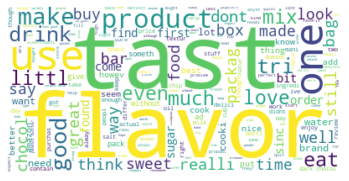

In [34]:
#Wordcloud for cluster 1
from wordcloud import WordCloud

data=''
for i in cluster1:
    data+=str(i)

wordcloud1 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

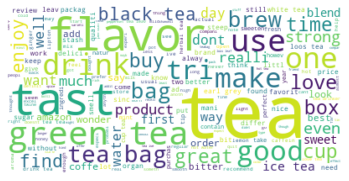

In [35]:
#Wordcloud for cluster 2

data=''
for i in cluster2:
    data+=str(i)

wordcloud2 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

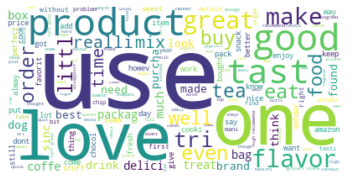

In [36]:
#Wordcloud for cluster 3

data=''
for i in cluster3:
    data+=str(i)

wordcloud3 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

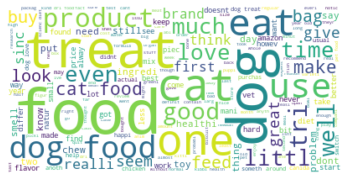

In [37]:
#Wordcloud for cluster 4

data=''
for i in cluster4:
    data+=str(i)

wordcloud4 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis("off")
plt.show()

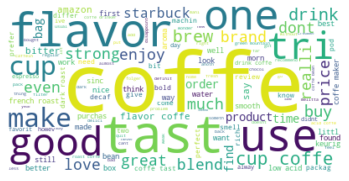

In [38]:
#Wordcloud for cluster 5

data=''
for i in cluster5:
    data+=str(i)

wordcloud5= WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud5, interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying K-Means Clustering on TFIDF

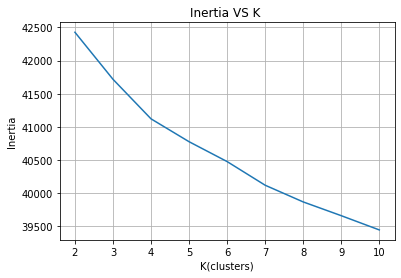

In [40]:
k=[2,3,4,5,6,7,8,9,10]
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(tfidf_X)
    inertia.append(model.inertia_)
    
#Applying elbow method to find best k
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [41]:
#at k=4 there is a point of deflection

model=KMeans(n_clusters=4, n_jobs=-1)
model.fit(tfidf_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [42]:
cluster1,cluster2,cluster3, cluster4=[],[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(X[i])
    elif model.labels_[i] == 1:
        cluster2.append(X[i])
    elif model.labels_[i] == 2:
        cluster3.append(X[i])
    else:
        cluster4.append(X[i])

### Wordclouds of clusters obtained after applying k-means on TFIDF

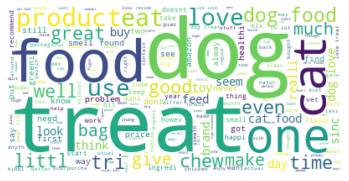

In [44]:
#Wordcloud for cluster 1

data=''
for i in cluster1:
    data+=str(i)

wordcloud1 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

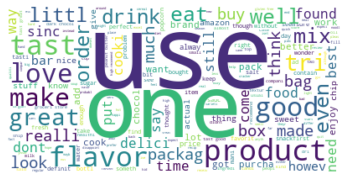

In [45]:
#Wordcloud for cluster 2

data=''
for i in cluster2:
    data+=str(i)

wordcloud2 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

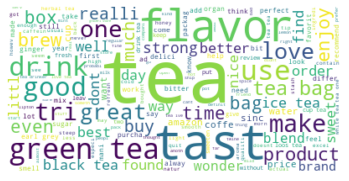

In [46]:
#Wordcloud for cluster 3

data=''
for i in cluster3:
    data+=str(i)

wordcloud3 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

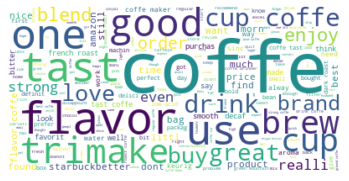

In [47]:
#Wordcloud for cluster 4

data=''
for i in cluster4:
    data+=str(i)

wordcloud4 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying K-Means Clustering on AVG W2V

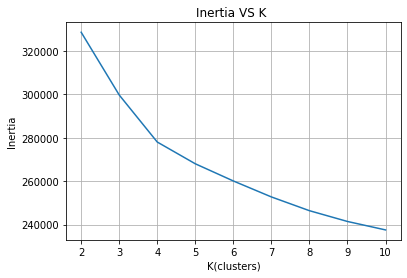

In [48]:
k=[2,3,4,5,6,7,8,9,10]

inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(avgw2v_X)
    inertia.append(model.inertia_)
    
#Applying elbow method to find best k  
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [49]:
#at k=4 there is a point of deflection

model=KMeans(n_clusters=4, n_jobs=-1)
model.fit(avgw2v_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [50]:
cluster1,cluster2,cluster3, cluster4=[],[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(X[i])
    elif model.labels_[i] == 1:
        cluster2.append(X[i])
    elif model.labels_[i] == 2:
        cluster3.append(X[i])
    else:
        cluster4.append(X[i])

### Wordclouds of clusters obtained after applying k-means on AVGW2V

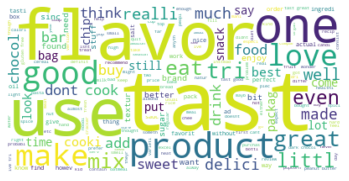

In [51]:
#Wordcloud for cluster 1

data=''
for i in cluster1:
    data+=str(i)

wordcloud1 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

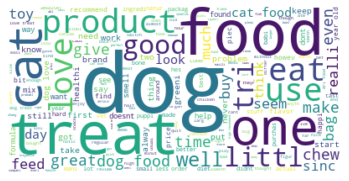

In [52]:
#Wordcloud for cluster 2

data=''
for i in cluster2:
    data+=str(i)

wordcloud2 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

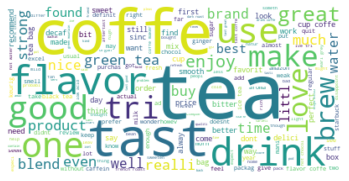

In [53]:
#Wordcloud for cluster 3

data=''
for i in cluster3:
    data+=str(i)

wordcloud3 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

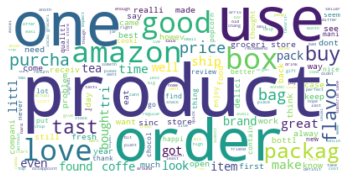

In [54]:
#Wordcloud for cluster 4

data=''
for i in cluster4:
    data+=str(i)

wordcloud4 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying K-Means Clustering on TFIDF W2V

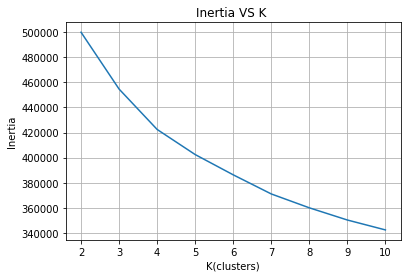

In [55]:
k=[2,3,4,5,6,7,8,9,10]

inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(tfidf_w2v_X)
    inertia.append(model.inertia_)
    
#Applying elbow method to find best k
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [56]:
#at k=3 there is a point of deflection

model=KMeans(n_clusters=3, n_jobs=-1)
model.fit(tfidf_w2v_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Wordclouds of clusters obtained after applying k-means on TFIDFW2V

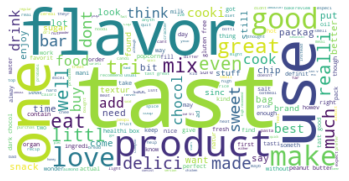

In [57]:
#Wordcloud for cluster 1

data=''
for i in cluster1:
    data+=str(i)

wordcloud1 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

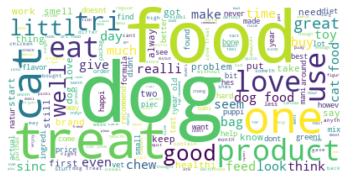

In [58]:
#Wordcloud for cluster 2

data=''
for i in cluster2:
    data+=str(i)

wordcloud2 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

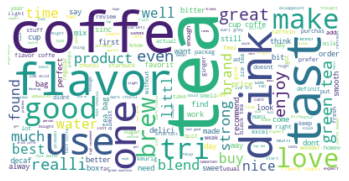

In [59]:
#Wordcloud for cluster 3

data=''
for i in cluster3:
    data+=str(i)

wordcloud3 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

## Agglomerative Clustering

### Applying Agglomerative Clustering on AVG W2V

In [60]:
X1  = final['CleanedText'][:5000].values

In [63]:
i=0
list_sent_a=[]
for sent in X1:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_a.append(filtered_sentence)

In [64]:
avgw2v_X1 = avg_w2v(list_sent_a)

5000
50


#### K = 2

In [65]:
from sklearn.cluster import AgglomerativeClustering

model=AgglomerativeClustering(n_clusters=2).fit(avgw2v_X1)

In [66]:
cluster1,cluster2=[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(X1[i])
    else:
        cluster2.append(X1[i])

### Wordclouds of 2 clusters obtained after applying agglomerative clustering on AVG W2V

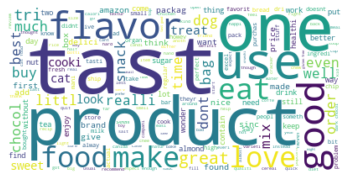

In [67]:
#Wordcloud for cluster 1

data=''
for i in cluster1:
    data+=str(i)

wordcloud1 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

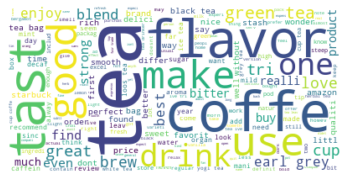

In [68]:
#Wordcloud for cluster 2

data=''
for i in cluster2:
    data+=str(i)

wordcloud2 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

#### K = 5

In [69]:
model=AgglomerativeClustering(n_clusters=5).fit(avgw2v_X1)

In [70]:
cluster1,cluster2,cluster3,cluster4,cluster5=[],[],[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(X1[i])
    elif model.labels_[i] == 1:
        cluster2.append(X1[i])
    elif model.labels_[i] == 2:
        cluster3.append(X1[i])
    elif model.labels_[i] == 3:
        cluster4.append(X1[i])
    else :
        cluster5.append(X1[i])

### Wordclouds of 5 clusters obtained after applying agglomerative clustering on AVG W2V

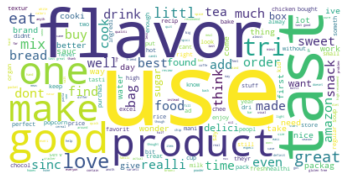

In [71]:
#Wordcloud for cluster 1

data=''
for i in cluster1:
    data+=str(i)

wordcloud1 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

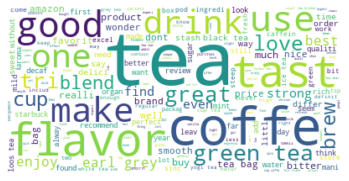

In [72]:
#Wordcloud for cluster 2

data=''
for i in cluster2:
    data+=str(i)

wordcloud2 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

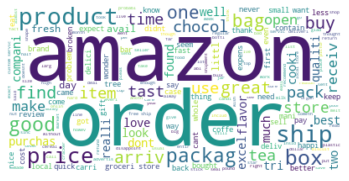

In [73]:
#Wordcloud for cluster 3

data=''
for i in cluster3:
    data+=str(i)

wordcloud3 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

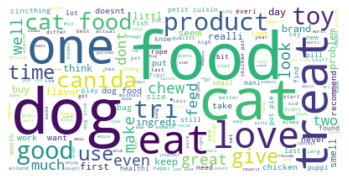

In [74]:
#Wordcloud for cluster 4

data=''
for i in cluster4:
    data+=str(i)

wordcloud4 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis("off")
plt.show()

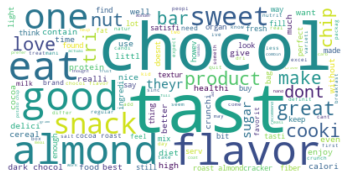

In [75]:
#Wordcloud for cluster 5

data=''
for i in cluster5:
    data+=str(i)

wordcloud5 = WordCloud(background_color="white").generate(data)

# Displaying the image:
plt.imshow(wordcloud5, interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying Agglomerative Clustering on TFIDF W2V

In [76]:
tfidf_X1 = tf_idf_vect.fit_transform(X1)

In [77]:
t = tf_idf_vect.get_feature_names()
tfidf_w2v_X1 = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in tqdm(list_sent_a):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_X1[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_w2v_X1.append(sent_vec)
    row += 1
print(len(tfidf_w2v_X1))
print(len(tfidf_w2v_X1[0]))

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:09<00:00, 72.45it/s]


5000
50


#### for k=2

In [78]:
model=AgglomerativeClustering(n_clusters=2).fit(tfidf_w2v_X1)

In [79]:
cluster1, cluster2 = [],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(X1[i])
    else:
        cluster2.append(X1[i])

### Wordclouds of 2 clusters obtained after applying agglomerative clustering on TFIDF W2V

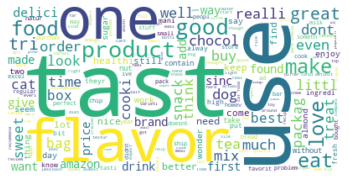

In [80]:
#Wordcloud for cluster 1

data=''
for i in cluster1:
    data+=str(i)

wordcloud1 = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

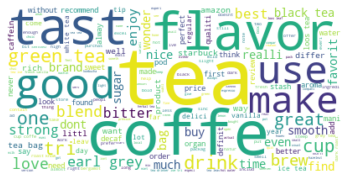

In [81]:
#Wordcloud for cluster 2

data=''
for i in cluster2:
    data+=str(i)

wordcloud2 = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

#### K = 5

In [82]:
model=AgglomerativeClustering(n_clusters=5).fit(tfidf_w2v_X1)

In [83]:
cluster1,cluster2,cluster3,cluster4,cluster5=[],[],[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(X1[i])
    elif model.labels_[i] == 1:
        cluster2.append(X1[i])
    elif model.labels_[i] == 2:
        cluster3.append(X1[i])
    elif model.labels_[i] == 3:
        cluster4.append(X1[i])
    else :
        cluster5.append(X1[i])

### Wordclouds of 5 clusters obtained after applying agglomerative clustering on TFIDF W2V

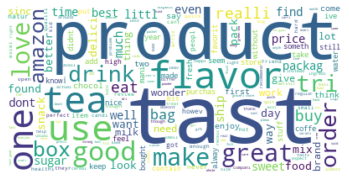

In [84]:
#Wordcloud for cluster 1

data=''
for i in cluster1:
    data+=str(i)

wordcloud1 = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

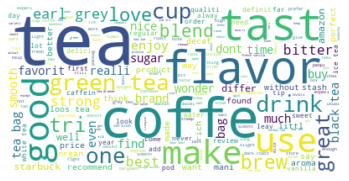

In [85]:
#Wordcloud for cluster 2

data=''
for i in cluster2:
    data+=str(i)

wordcloud2 = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

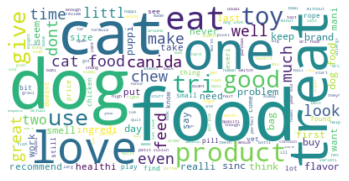

In [86]:
#Wordcloud for cluster 3

data=''
for i in cluster3:
    data+=str(i)

wordcloud3 = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

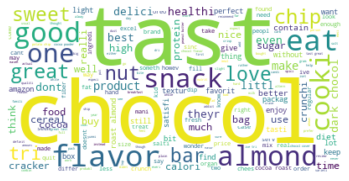

In [87]:
#Wordcloud for cluster 4

data=''
for i in cluster4:
    data+=str(i)

wordcloud4 = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis("off")
plt.show()

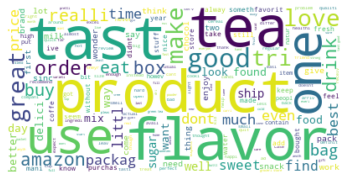

In [88]:
#Wordcloud for cluster 5

data=''
for i in cluster1:
    data+=str(i)

wordcloud5 = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud5, interpolation='bilinear')
plt.axis("off")
plt.show()

## DBSCAN Clustering

### Applying DBSCAN on AVG W2V

In [117]:
w2v_model1 = gensim.models.Word2Vec(list_sent,min_count=5,size=200,workers=4)
w2v_words1 = list(w2v_model1.wv.vocab)

In [118]:
def avg_w2v1(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(200) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words1:
                vec = w2v_model1.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)        
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [119]:
avgw2v_X1 = avg_w2v1(list_sent_a)

5000
200


In [121]:
from sklearn.preprocessing import StandardScaler
data=StandardScaler().fit_transform(avgw2v_X1)

### Finding Optimal eps

In [128]:
def nth_neighbor_distance(X_vectors, minpoints):
    nearest_distances = []
    for data in X_vectors:
        sq_dis = np.sum((X_vectors-data)**2,axis=1)
        nearest_distances.append(sq_dis[minpoints])
    return np.sqrt(np.array(nearest_distances))

#Function to obtain the best value of EPS.
def plot_elbow_db(X_vectors, min_points):
    dist = nth_neighbor_distance(X_vectors, min_points)
    sorted_dist = np.sort(dist)
    indexes = list(range(0,X_vectors.shape[0]))

    #Plot K_Values vs Loss Values
    plt.figure(figsize=(10,5))
    plt.plot(indexes, sorted_dist)
    plt.title('Point Index vs EPS')
    plt.xlabel('Point Index')
    plt.ylabel('Epsilon/Distances')
    plt.show()
    
    #optimal_eps = float(input("Please select the optimal value of eps from the above elbow plot and press enter : "))
    #print("\nThe optimal value of eps selected from the elbow method is {}".format(optimal_eps))
    #return optimal_eps

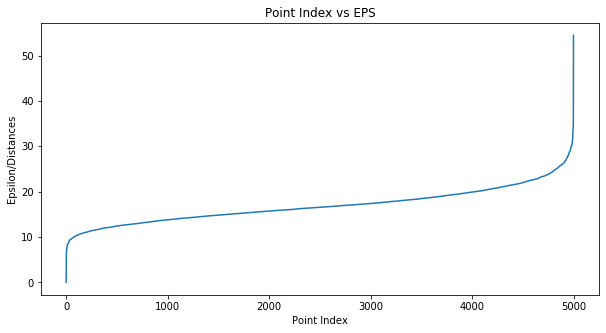

In [129]:
min_points = data.shape[1] * 2  #Minpoints = Twice the size of features.
optimal_eps_value = plot_elbow_db(data, min_points)

In [132]:
#we can see that point of inflexion is at eps=15
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=15, n_jobs=-1)
dbscan.fit(data)
print('No of clusters: ',len(set(dbscan.labels_)))
print('Cluster labels are: ',set(dbscan.labels_))

No of clusters:  2
Cluster labels are:  {0, -1}


In [131]:
#ignoring -1 cluster label as it is for noisy cluster
cluster1=[]
for i in range(dbscan.labels_.shape[0]):
    if dbscan.labels_[i] == 0:
        cluster1.append(X1[i])

### Wordcloud of cluster obtained after applying DBSCAN on AVG W2V

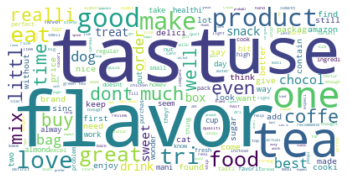

In [133]:
#Wordcloud for cluster 1
data=''
for i in cluster1:
    data+=str(i)

wordcloud1 = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying DBSCAN on TFIDF W2V

In [134]:
t = tf_idf_vect.get_feature_names()
tfidf_w2v_X2 = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in tqdm(list_sent_a):
    sent_vec = np.zeros(200)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            tfidf = tfidf_X1[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_w2v_X2.append(sent_vec)
    row += 1
print(len(tfidf_w2v_X2))
print(len(tfidf_w2v_X2[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:42<00:00, 116.57it/s]


5000
200


In [136]:
data1=StandardScaler().fit_transform(tfidf_w2v_X2)

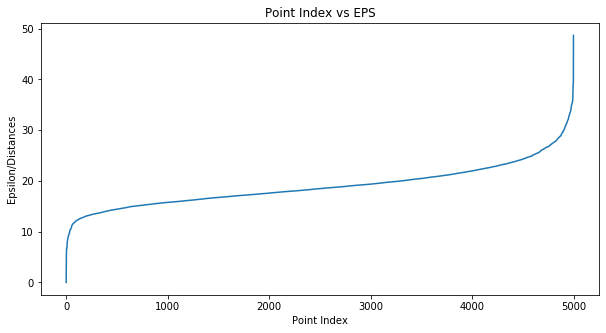

In [137]:
min_points = data1.shape[1] * 2  #Minpoints = Twice the size of features.
optimal_eps_value = plot_elbow_db(data1, min_points)

In [138]:
#we can see that point of inflexion is at eps=14

dbscan = DBSCAN(eps=14, n_jobs=-1)
dbscan.fit(data1)
print('No of clusters: ',len(set(dbscan.labels_)))
print('Cluster labels are: ',set(dbscan.labels_))

No of clusters:  2
Cluster labels are:  {0, -1}


In [139]:
#ignoring -1 cluster label as it is for noisy cluster
cluster1=[]
for i in range(dbscan.labels_.shape[0]):
    if dbscan.labels_[i] == 0:
        cluster1.append(X1[i])

### Wordcloud of cluster obtained after applying DBSCAN on TFIDF W2V

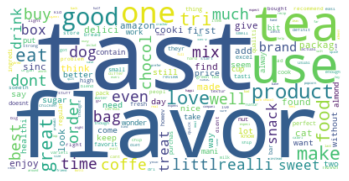

In [140]:
#Wordcloud for cluster 1
data=''
for i in cluster1:
    data+=str(i)

wordcloud1 = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

## Conclusion

In [141]:
#prettytable for kmeans
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Best k"]
x.add_row(['BOW','5'])
x.add_row(['TFIDF','4'])
x.add_row(['AVG W2vec','4'])
x.add_row(['TFIDF W2vec','3'])
print(x)

+-------------+--------+
|  Vectorizer | Best k |
+-------------+--------+
|     BOW     |   5    |
|    TFIDF    |   4    |
|  AVG W2vec  |   4    |
| TFIDF W2vec |   3    |
+-------------+--------+


In [142]:
#prettytable for DBSCAN
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Optimal eps"]

x.add_row(['AVG W2vec','15'])
x.add_row(['TFIDF W2vec','14'])
print(x)

+-------------+-------------+
|  Vectorizer | Optimal eps |
+-------------+-------------+
|  AVG W2vec  |      15     |
| TFIDF W2vec |      14     |
+-------------+-------------+


#### Procedures and Observations

1) For K-means clustering, total 50k datapoints taken where as for Agglomerative and DBSCAN clustering, we took 5k datapoints because of expensive run-time.

2) For K-means clustering, we applied k-means for different value of k and selected optimal k with the help of elbow method from graph between inertia vs k.

3) For agglomerative clustering we took n_clusters=[2,5] and applied algorithm on it and plotted the word cloud for each clusters.

5) And at the end we applied DBSCAN on Avg-W2vec and TFIDF-W2vec, for optimal eps we first calculated the nth distance from each point, sorted them and plotted the curve between points and distances and again we applied elbow method to figure out the best eps(At point of inflexion).